In [124]:
import values_mod_param as physical
import cbind_mod_physic as mod_physic
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import matplotlib as mpl
#import os
import matplotlib.colors as colors

from cartopy import config
import cartopy.crs as ccrs
import cartopy

import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

import cartopy.feature as cfeature

import hvplot.xarray
import geoviews as gv
import holoviews as hv

from matplotlib import cm
import netCDF4 as nc

In [3]:
topoCTRL = xr.open_dataset("topo_glmask_GL2_CTRL.nc")
topoGT1 = xr.open_dataset("topo_GT1.nc")
topoGT2 = xr.open_dataset("topo_GT2.nc")
topoGT7 = xr.open_dataset("topo_GT7.nc")

prCTRL = xr.open_dataset('CTRL2003_2008_PR_TM.nc').load()
prGT1 = xr.open_dataset('GT12003_2008_PR_TM.nc').load()
prGT2 = xr.open_dataset('GT22003_2008_PR_TM.nc').load()
prGT7 = xr.open_dataset('GT72003_2008_PR_TM.nc').load()

GT1_pr = prGT1.pr[0,0,:,:]
GT2_pr = prGT2.pr[0,0,:,:]
GT7_pr = prGT7.pr[0,0,:,:]

# CTRL

(602, 402)
(429, 293)
(429, 293)
(429, 293)
Different percentages where the following amount of precip with lower values:
50% 308.95037841796875 mm/year
75% 506.4690246582031
80% 570.2839477539063
90% 880.8801513671882
99.9% 6245.953445312783 : So 0.01% of the precip is higher than 6245.953445312783


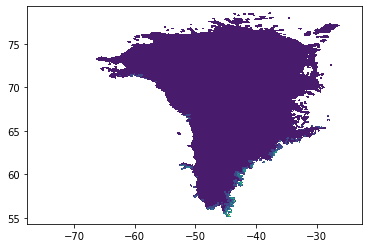

In [4]:
CTRL_pr = np.squeeze(prCTRL.pr)

iceCTRL = xr.open_dataset("glmask_GL2.nc")

#print(iceCTRL)

ice_mask = np.squeeze(iceCTRL.var232)
print(ice_mask.shape)

lats = iceCTRL.variables['lat'][:429,:293]
lons = iceCTRL.variables['lon'][:429,:293]

print(lats.shape)
print(lons.shape)

only_im = ice_mask.where(ice_mask>0,drop=True)

da = xr.DataArray(CTRL_pr*365.25)
im_prCTRL = da.where(ice_mask>0.,drop=True)

#plt.contourf(lon,lat,im_prCTRL)
#plt.colorbar()


print(im_prCTRL.shape)


#plt.figure(figsize=(10,6),dpi=100) 
#ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-50.0, central_latitude=39.0, 
                                           #    false_easting=0.0, false_northing=0.0, secant_latitudes=None, 
                                            #   standard_parallels=None, globe=None, cutoff=-30))

plt.contourf(lons, lats, im_prCTRL)#, transform=ccrs.LambertConformal())



fifty_per = np.nanpercentile(im_prCTRL,50)
seventyfive_per = np.nanpercentile(im_prCTRL,75)
eighty_per = np.nanpercentile(im_prCTRL,80)
ninty_per = np.nanpercentile(im_prCTRL,90)
nintynine_per = np.nanpercentile(im_prCTRL,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

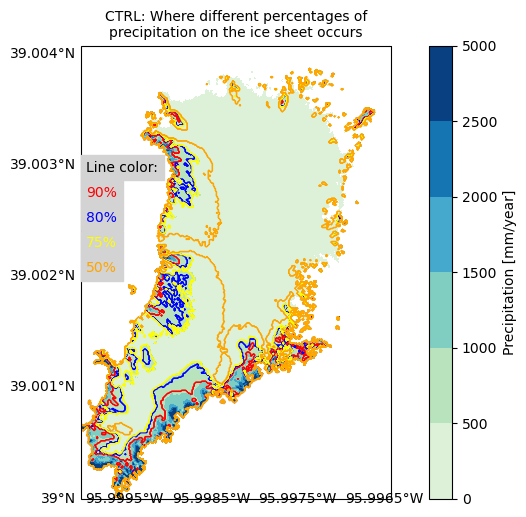

In [5]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

#ax.get_xticks()
#ax.get_yticks()

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

bounds = np.array([0,500,1000,1500,2000,2500,5000])
norm = colors.BoundaryNorm(bounds,cmp.N)

data1 = np.zeros_like(im_prCTRL)
data1[im_prCTRL >= fifty_per] = 1

data2 = np.zeros_like(im_prCTRL)
data2[im_prCTRL >= seventyfive_per] = 1

data3 = np.zeros_like(im_prCTRL)
data3[im_prCTRL >= eighty_per] = 1

data4 = np.zeros_like(im_prCTRL)
data4[im_prCTRL >= ninty_per] = 1


data = ax.pcolormesh(im_prCTRL,cmap=cmp,norm=norm)


cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.4)
d3 = ax.contour(data3,colors='blue',linewidths=0.4)
d2 = ax.contour(data2,colors='yellow',linewidths=0.4)
d1 = ax.contour(data1,colors='orange',linewidths=0.4)

ax.set_title('CTRL: Where different percentages of\nprecipitation on the ice sheet occurs',fontsize=10)
ax.coastlines()

ax.text(5,325,'Line color:',color='black',backgroundcolor='lightgray',fontsize=10)
ax.text(5,300,'90%',color='r',backgroundcolor='lightgray')
ax.text(5,275,'80%',color='b',backgroundcolor='lightgray')
ax.text(5,250,'75%',color='yellow',backgroundcolor='lightgray')
ax.text(5,225,'50%',color='orange',backgroundcolor='lightgray')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.ylocator = LatitudeLocator()
#gl.xformatter = LongitudeFormatter()
#gl.yformatter = LatitudeFormatter()

### 2m-air temperature and elevation

In [32]:
CTRL_temp = xr.open_dataset("TAS_CTRL.nc")

tas_ctrl = np.squeeze(CTRL_temp.tas)

tas_ctrl_im = tas_ctrl.where(ice_mask>0,drop=True)

tas_ctrl_2 = np.where(ice_mask>0,tas_ctrl,np.NaN)

print(tas_ctrl_im.shape)

#Rescaled format

lon = np.squeeze(CTRL_temp.lon)
lat = np.squeeze(CTRL_temp.lat)

lon_recaled = lon.where(ice_mask>0,drop=True)
lat_recaled = lat.where(ice_mask>0,drop=True)

print(lon_recaled.shape)

(429, 293)
<xarray.DataArray 'lon' (y: 602, x: 402)>
[242004 values with dtype=float32]
Coordinates:
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    long_name:            longitude
    units:                degrees_east
    standard_name:        longitude
    _CoordinateAxisType:  Lon
(429, 293)


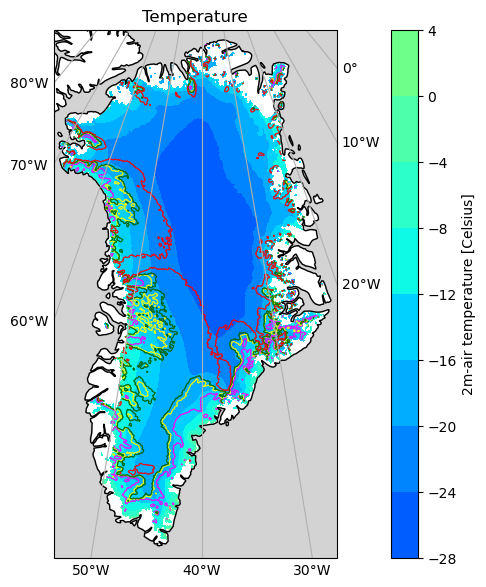

In [98]:
fig = plt.figure(figsize=(7,7),dpi=100)
plt.clf()

ax = fig.add_subplot(1,1,1,projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-40,central_latitude=75.0))
ax.set_extent([-53.6,-27.6,59.3,84],crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m', edgecolor='face',facecolor='lightgray'))
ax.coastlines('50m')

gl = ax.gridlines(crs=ccrs.PlateCarree(),xlocs=np.arange(-180,180,10),ylocs=np.arange(50,90,10),
                  draw_labels=True,x_inline=False, y_inline=False)
gl.right_labels=False
gl.left_labels=False
gl.top_labels=False
gl.rotate_labels=False
gl.ylines = False #grids
#gl.xlines = False #grids

jet_big = cm.get_cmap('jet')
cmp = colors.ListedColormap(jet_big(np.linspace(0.2, 0.5, 250)))

data = ax.contourf(lon_recaled,lat_recaled,tas_ctrl_im-273.15,cmap=cmp,transform=ccrs.PlateCarree())
ax.set_title('Temperature')
cbar = plt.colorbar(data,pad=0.1)
cbar.set_label('2m-air temperature [Celsius]')
cbar.ax.tick_params(labelsize=10)


data1 = np.zeros_like(im_prCTRL)
data1[im_prCTRL >= fifty_per] = 1

data2 = np.zeros_like(im_prCTRL)
data2[im_prCTRL >= seventyfive_per] = 1

data3 = np.zeros_like(im_prCTRL)
data3[im_prCTRL >= eighty_per] = 1

data4 = np.zeros_like(im_prCTRL)
data4[im_prCTRL >= ninty_per] = 1

d4 = ax.contour(lon_recaled,lat_recaled,data4,colors='magenta',linewidths=0.2,transform=ccrs.PlateCarree())
d3 = ax.contour(lon_recaled,lat_recaled,data3,colors='yellow',linewidths=0.2,transform=ccrs.PlateCarree())
d2 = ax.contour(lon_recaled,lat_recaled,data2,colors='darkgreen',linewidths=0.2,transform=ccrs.PlateCarree())
d1 = ax.contour(lon_recaled,lat_recaled,data1,colors='red',linewidths=0.2,transform=ccrs.PlateCarree())


plt.show()

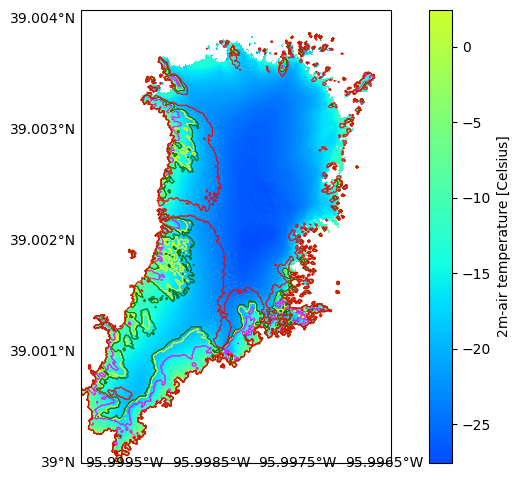

In [13]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())#central_longitude=-40,central_latitude=70))

jet_big = cm.get_cmap('jet')
cmp = colors.ListedColormap(jet_big(np.linspace(0.2, 0.6, 250)))

data = ax.pcolormesh(tas_ctrl_im-273.15,cmap=cmp)
cbar = plt.colorbar(data)
cbar.set_label('2m-air temperature [Celsius]')



data1 = np.zeros_like(im_prCTRL)
data1[im_prCTRL >= fifty_per] = 1

data2 = np.zeros_like(im_prCTRL)
data2[im_prCTRL >= seventyfive_per] = 1

data3 = np.zeros_like(im_prCTRL)
data3[im_prCTRL >= eighty_per] = 1

data4 = np.zeros_like(im_prCTRL)
data4[im_prCTRL >= ninty_per] = 1

d4 = ax.contour(data4,colors='magenta',linewidths=0.2)
d3 = ax.contour(data3,colors='yellow',linewidths=0.2)
d2 = ax.contour(data2,colors='darkgreen',linewidths=0.2)
d1 = ax.contour(data1,colors='red',linewidths=0.2)


import matplotlib.ticker as mticker

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels = False
gl.xlines = False
gl.ylines = False
#gl.ylocator = LatitudeLocator()
#gl.xlocator = mticker.FixedLocator([-47, 0, 45])

#ax.clabel(d1, use_clabeltext=True, Text='50%')


#import cartopy.mpl.ticker as cticker

        # Longlitude labels
#ax.set_xticks(np.arange(-180,181,60), crs=ccrs.LambertConformal())
#lon_formatter = mticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
#ax.set_yticks(np.arange(-90,91,30), crs=ccrs.LambertConformal())
#lat_formatter = mticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

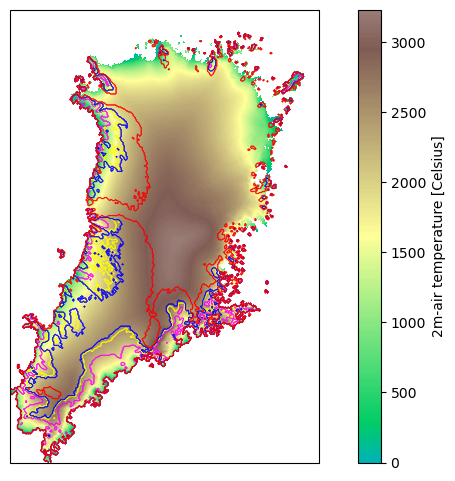

In [426]:
topo_ctrl = np.squeeze(topoCTRL.var6)

topo_ctrl_im = topo_ctrl.where(ice_mask>0,drop=True)

#plt.pcolormesh(topo_ctrl_im)
#plt.colorbar()

plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())#central_longitude=-40,central_latitude=70))

jet_big = cm.get_cmap('terrain')
cmp = colors.ListedColormap(jet_big(np.linspace(0.2, 0.8, 250)))

data = ax.pcolormesh(topo_ctrl_im,cmap=cmp)
cbar = plt.colorbar(data)
cbar.set_label('2m-air temperature [Celsius]')



data1 = np.zeros_like(im_prCTRL)
data1[im_prCTRL >= fifty_per] = 1

data2 = np.zeros_like(im_prCTRL)
data2[im_prCTRL >= seventyfive_per] = 1

data3 = np.zeros_like(im_prCTRL)
data3[im_prCTRL >= eighty_per] = 1

data4 = np.zeros_like(im_prCTRL)
data4[im_prCTRL >= ninty_per] = 1

d4 = ax.contour(data4,colors='magenta',linewidths=0.2)
d3 = ax.contour(data3,colors='yellow',linewidths=0.2)
d2 = ax.contour(data2,colors='blue',linewidths=0.2)
d1 = ax.contour(data1,colors='red',linewidths=0.2)

# GT1

Different percentages where the following amount of precip with lower values:
50% 442.2411193847656 mm/year
75% 788.8905639648438
80% 882.6385009765626
90% 1160.6869140625
99.9% 4529.4823007812565 : So 0.01% of the precip is higher than 4529.4823007812565


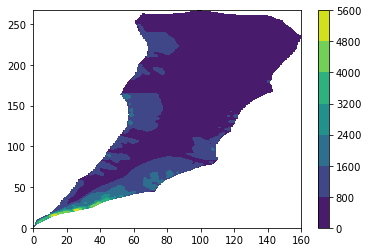

In [74]:
#Ice Mask

ice_mask = np.squeeze(topoGT1.ice_mask)

da = xr.DataArray(GT1_pr*365.25)
im_pr = da.where(ice_mask>0.,drop=True)

#print(gl_pr.shape)
plt.contourf(im_pr) 
plt.colorbar()

fifty_per = np.nanpercentile(im_pr,50)
seventyfive_per = np.nanpercentile(im_pr,75)
eighty_per = np.nanpercentile(im_pr,80)
ninty_per = np.nanpercentile(im_pr,90)
nintynine_per = np.nanpercentile(im_pr,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

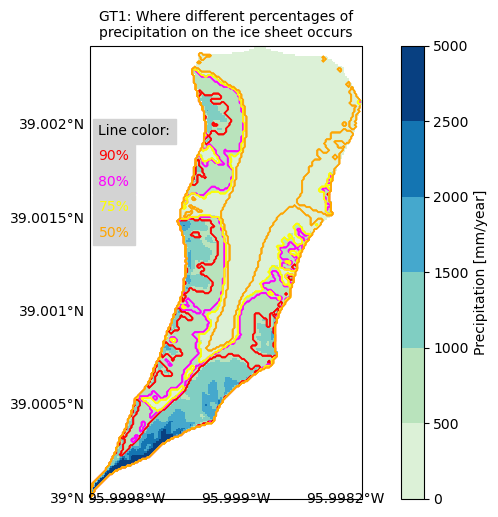

In [432]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

bounds = np.array([0,500,1000,1500,2000,2500,5000])
norm = colors.BoundaryNorm(bounds,cmp.N)

data1 = np.zeros_like(im_pr)
data1[im_pr >= fifty_per] = 1

data2 = np.zeros_like(im_pr)
data2[im_pr >= seventyfive_per] = 1

data3 = np.zeros_like(im_pr)
data3[im_pr >= eighty_per] = 1

data4 = np.zeros_like(im_pr)
data4[im_pr >= ninty_per] = 1


data = ax.pcolormesh(im_pr,cmap=cmp,norm=norm)

cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.4)
d3 = ax.contour(data3,colors='fuchsia',linewidths=0.4)
d2 = ax.contour(data2,colors='yellow',linewidths=0.4)
d1 = ax.contour(data1,colors='orange',linewidths=0.4)

ax.set_title('GT1: Where different percentages of\nprecipitation on the ice sheet occurs',fontsize=10)

ax.text(5,215,'Line color:',color='black',backgroundcolor='lightgray')
ax.text(5,200,'90%',color='r',backgroundcolor='lightgray')
ax.text(5,185,'80%',color='fuchsia',backgroundcolor='lightgray')
ax.text(5,170,'75%',color='yellow',backgroundcolor='lightgray')
ax.text(5,155,'50%',color='orange',backgroundcolor='lightgray')

ax.margins(x=0, y=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# GT2

Different percentages where the following amount of precip with lower values:
50% 316.7669677734375 mm/year
75% 616.1466064453125
80% 773.0763061523438
90% 1265.4909179687504
99.9% 4617.04849414066 : So 0.01% of the precip is higher than 4617.04849414066


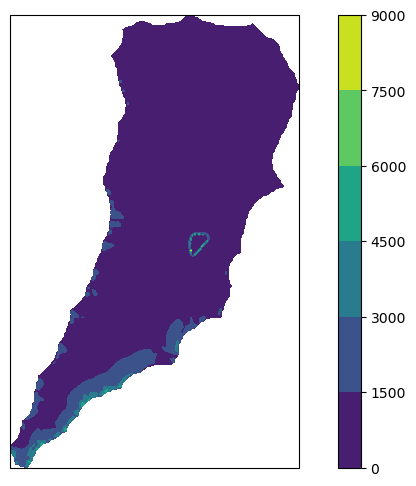

In [163]:
#Ice Mask for GT2

plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

ice_mask = np.squeeze(topoGT2.ice_mask)

da = xr.DataArray(GT2_pr*365.25)
im_pr2 = da.where(ice_mask>0.,drop=True)

plt.contourf(im_pr2)
plt.colorbar()

fifty_per = np.nanpercentile(im_pr2,50)
seventyfive_per = np.nanpercentile(im_pr2,75)
eighty_per = np.nanpercentile(im_pr2,80)
ninty_per = np.nanpercentile(im_pr2,90)
nintynine_per = np.nanpercentile(im_pr2,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

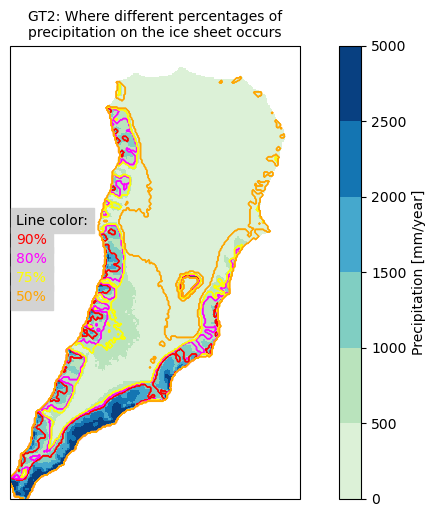

In [435]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

bounds = np.array([0,500,1000,1500,2000,2500,5000])
norm = colors.BoundaryNorm(bounds,cmp.N)

data1 = np.zeros_like(im_pr2)
data1[im_pr2 >= fifty_per] = 1

data2 = np.zeros_like(im_pr2)
data2[im_pr2 >= seventyfive_per] = 1

data3 = np.zeros_like(im_pr2)
data3[im_pr2 >= eighty_per] = 1

data4 = np.zeros_like(im_pr2)
data4[im_pr2 >= ninty_per] = 1


data = ax.pcolormesh(im_pr2,cmap=cmp,norm=norm)

cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.4)
d3 = ax.contour(data3,colors='fuchsia',linewidths=0.4)
d2 = ax.contour(data2,colors='yellow',linewidths=0.4)
d1 = ax.contour(data1,colors='orange',linewidths=0.4)

ax.set_title('GT2: Where different percentages of\nprecipitation on the ice sheet occurs',fontsize=10)

ax.text(5,215,'Line color:',color='black',backgroundcolor='lightgray')
ax.text(5,200,'90%',color='r',backgroundcolor='lightgray')
ax.text(5,185,'80%',color='fuchsia',backgroundcolor='lightgray')
ax.text(5,170,'75%',color='yellow',backgroundcolor='lightgray')
ax.text(5,155,'50%',color='orange',backgroundcolor='lightgray')

ax.coastlines()

# GT7

Different percentages where the following amount of precip with lower values:
50% 319.07066345214844 mm/year
75% 551.1076507568359
80% 624.0457641601566
90% 966.8741577148437
99.9% 4750.8119526367245 : So 0.01% of the precip is higher than 4750.8119526367245


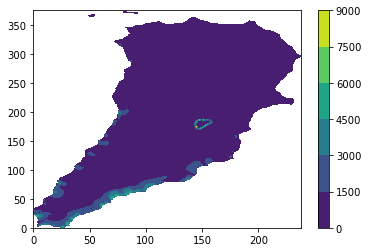

In [167]:
#Ice Mask for GT7

ice_mask = np.squeeze(topoGT7.ice_mask)

da = xr.DataArray(GT7_pr*365.25)
im_pr7 = da.where(ice_mask>0.,drop=True)

#print(im_pr7)
#print(GT7_pr)

plt.contourf(im_pr7)
plt.colorbar()

fifty_per = np.nanpercentile(im_pr7,50)
seventyfive_per = np.nanpercentile(im_pr7,75)
eighty_per = np.nanpercentile(im_pr7,80)
ninty_per = np.nanpercentile(im_pr7,90)
nintynine_per = np.nanpercentile(im_pr7,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

Text(5, 155, '50%')

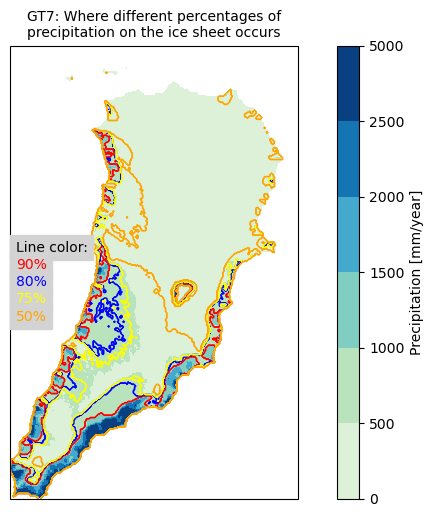

In [298]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

bounds = np.array([0,500,1000,1500,2000,2500,5000])
norm = colors.BoundaryNorm(bounds,cmp.N)

data1 = np.zeros_like(im_pr7)
data1[im_pr7 >= fifty_per] = 1

data2 = np.zeros_like(im_pr7)
data2[im_pr7 >= seventyfive_per] = 1

data3 = np.zeros_like(im_pr7)
data3[im_pr7 >= eighty_per] = 1

data4 = np.zeros_like(im_pr7)
data4[im_pr7 >= ninty_per] = 1


data = ax.pcolormesh(im_pr7,cmap=cmp,norm=norm)

cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.4)
d3 = ax.contour(data3,colors='blue',linewidths=0.4)
d2 = ax.contour(data2,colors='yellow',linewidths=0.4)
d1 = ax.contour(data1,colors='orange',linewidths=0.4)

ax.set_title('GT7: Where different percentages of\nprecipitation on the ice sheet occurs',fontsize=10)

ax.text(5,215,'Line color:',color='black',backgroundcolor='lightgray')
ax.text(5,200,'90%',color='r',backgroundcolor='lightgray')
ax.text(5,185,'80%',color='b',backgroundcolor='lightgray')
ax.text(5,170,'75%',color='yellow',backgroundcolor='lightgray')
ax.text(5,155,'50%',color='orange',backgroundcolor='lightgray')

# For each region 

<xarray.DataArray 'pr' (y: 429, x: 293)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lon      (y, x) float32 -46.75 -46.67 -46.58 -46.49 ... -10.57 -10.12 -9.685
    lat      (y, x) float32 59.37 59.39 59.41 59.43 ... 83.73 83.72 83.71 83.7
    height   float64 0.0
Dimensions without coordinates: y, x
<xarray.DataArray 'pr' (y: 215, x: 146)>
array([[      nan,       nan,       nan, ..., 296.37024, 289.19107,
        282.6529 ],
       [      nan,       nan,       nan, ..., 290.06433, 285.69647,
        281.12378],
       [      nan,       nan,       nan, ..., 286.9365 , 281.9973 ,
        276.56107],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       na

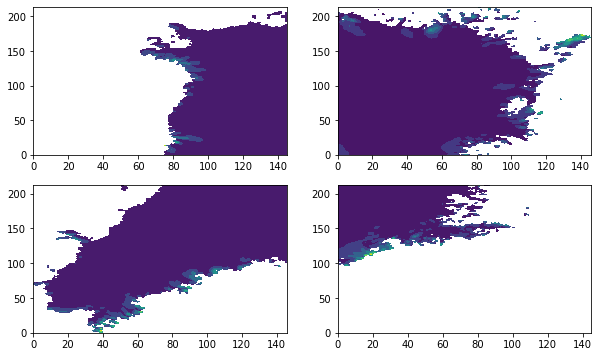

In [280]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))


print(im_prCTRL)

nw_gl = im_prCTRL[214:429,0:146]
sw_gl = im_prCTRL[:214,:147]
se_gl = im_prCTRL[:214,147:293]
ne_gl = im_prCTRL[214:429,146:293]

print(nw_gl)



data1 = np.zeros_like(nw_gl)
data1[nw_gl >= fifty_per] = 1

data2 = np.zeros_like(nw_gl)
data2[nw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(nw_gl)
data3[nw_gl >= eighty_per] = 1

data4 = np.zeros_like(nw_gl)
data4[nw_gl >= ninty_per] = 1


ax1.contourf(nw_gl)
ax2.contourf(ne_gl)
ax3.contourf(sw_gl)
ax4.contourf(se_gl)

Different percentages where the following amount of precip with lower values:
50% 333.9051208496094 mm/year
75% 484.4423828125
80% 536.0427978515625
90% 701.8291137695313
99.9% 2682.1039091797074 : So 0.01% of the precip is higher than 2682.1039091797074


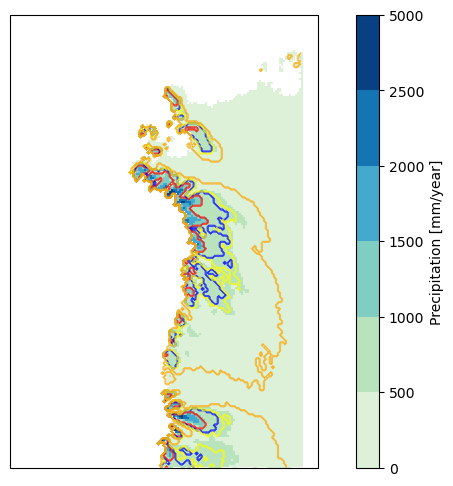

In [302]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

data1 = np.zeros_like(nw_gl)
data1[nw_gl >= fifty_per] = 1

data2 = np.zeros_like(nw_gl)
data2[nw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(nw_gl)
data3[nw_gl >= eighty_per] = 1

data4 = np.zeros_like(nw_gl)
data4[nw_gl >= ninty_per] = 1

data = ax.pcolormesh(nw_gl,cmap=cmp,norm=norm)
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2) 
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(nw_gl,50)
seventyfive_per = np.nanpercentile(nw_gl,75)
eighty_per = np.nanpercentile(nw_gl,80)
ninty_per = np.nanpercentile(nw_gl,90)
nintynine_per = np.nanpercentile(nw_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

Different percentages where the following amount of precip with lower values:
50% 502.7298278808594 mm/year
75% 767.4318542480469
80% 919.2881225585938
90% 1455.6418701171876
99.9% 7878.524726562762 : So 0.01% of the precip is higher than 7878.524726562762


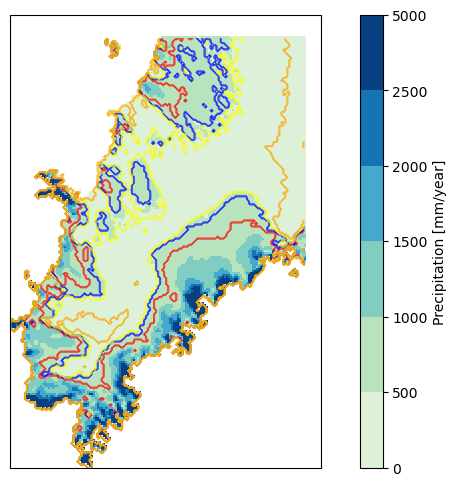

In [303]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

data1 = np.zeros_like(sw_gl)
data1[sw_gl >= fifty_per] = 1

data2 = np.zeros_like(sw_gl)
data2[sw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(sw_gl)
data3[sw_gl >= eighty_per] = 1

data4 = np.zeros_like(sw_gl)
data4[sw_gl >= ninty_per] = 1

data = ax.pcolormesh(sw_gl,cmap=cmp,norm=norm)
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(sw_gl,50)
seventyfive_per = np.nanpercentile(sw_gl,75)
eighty_per = np.nanpercentile(sw_gl,80)
ninty_per = np.nanpercentile(sw_gl,90)
nintynine_per = np.nanpercentile(sw_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

Different percentages where the following amount of precip with lower values:
50% 354.48341369628906 mm/year
75% 693.7300415039062
80% 830.0131347656254
90% 1263.3407836914066
99.9% 5666.530863281259 : So 0.01% of the precip is higher than 5666.530863281259


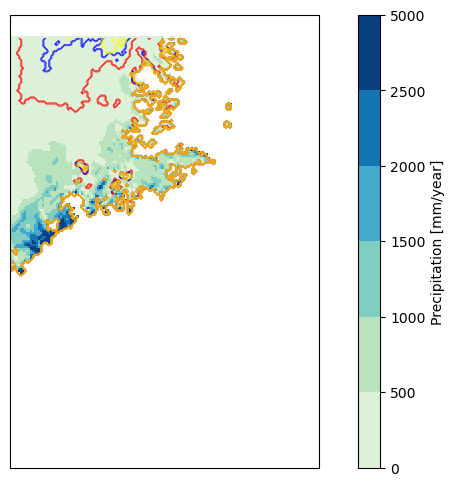

In [307]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

data1 = np.zeros_like(se_gl)
data1[se_gl >= fifty_per] = 1

data2 = np.zeros_like(se_gl)
data2[se_gl >= seventyfive_per] = 1

data3 = np.zeros_like(se_gl)
data3[se_gl >= eighty_per] = 1

data4 = np.zeros_like(se_gl)
data4[se_gl >= ninty_per] = 1

data = ax.pcolormesh(se_gl,cmap=cmp,norm=norm)
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')
d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(se_gl,50)
seventyfive_per = np.nanpercentile(se_gl,75)
eighty_per = np.nanpercentile(se_gl,80)
ninty_per = np.nanpercentile(se_gl,90)
nintynine_per = np.nanpercentile(se_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

Different percentages where the following amount of precip with lower values:
50% 139.3596649169922 mm/year
75% 181.1734733581543
80% 197.26460266113278
90% 251.88942565917975 : So regions where precip is over 251 mm/year is only 10% of all precip
99.9% 1367.3483636475087 : So 0.01% of the precip is higher than 1367.3483636475087


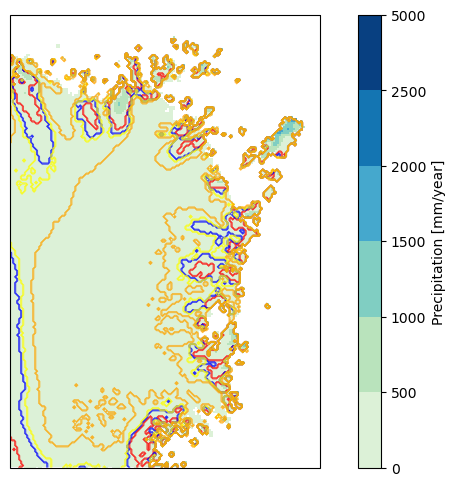

In [439]:
plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())

data1 = np.zeros_like(ne_gl)
data1[ne_gl >= fifty_per] = 1

data2 = np.zeros_like(ne_gl)
data2[ne_gl >= seventyfive_per] = 1

data3 = np.zeros_like(ne_gl)
data3[ne_gl >= eighty_per] = 1

data4 = np.zeros_like(ne_gl)
data4[ne_gl >= ninty_per] = 1

data = ax.pcolormesh(ne_gl,cmap=cmp,norm=norm)
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')
d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(ne_gl,50)
seventyfive_per = np.nanpercentile(ne_gl,75)
eighty_per = np.nanpercentile(ne_gl,80)
ninty_per = np.nanpercentile(ne_gl,90)
nintynine_per = np.nanpercentile(ne_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per,': So regions where precip is over 251 mm/year is only 10% of all precip')
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

GT1

(268, 161)
<xarray.DataArray 'pr' (y: 134, x: 90)>
array([[ 942.52203,        nan,        nan, ...,        nan,        nan,
               nan],
       [2283.777  ,        nan,        nan, ...,        nan,        nan,
               nan],
       [1557.8114 , 1858.4125 ,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,  224.04555,  214.90985,
         207.09354],
       [       nan,        nan,        nan, ...,  220.40634,  211.92992,
         204.61755],
       [       nan,        nan,        nan, ...,  215.57806,  207.86986,
         204.59502]], dtype=float32)
Coordinates:
  * y        (y) int64 188 189 190 191 192 193 194 ... 316 317 318 319 320 321
  * x        (x) int64 112 113 114 115 116 117 118 ... 196 197 198 199 200 201
    lon      (y, x) float32 -45.38 -45.27 -45.17 -45.06 ... -41.09 -40.93 -40.77
    lat      (y, x) float32 65.18 65.2 65.22 65.24 ... 72.96 72.98 73.0 73.02
    height   float64 0.0
  

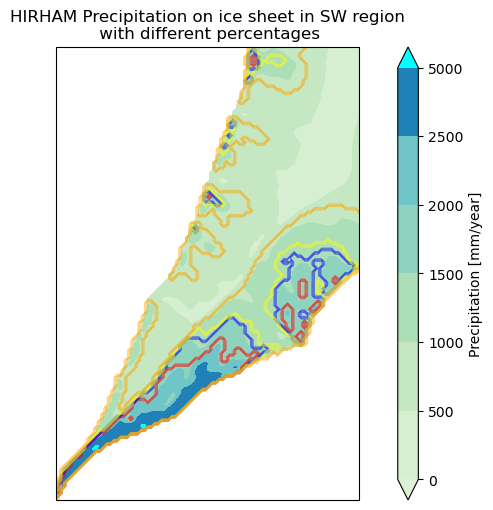

In [157]:
ice_mask = np.squeeze(topoGT1.ice_mask)

da = xr.DataArray(GT1_pr*365.25)
im_pr = da.where(ice_mask>0.,drop=True)

print(im_pr.shape)


plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())
ax.coastlines();
ax.set_title('HIRHAM Precipitation on ice sheet in SW region\n with different percentages')

sw_gl = im_pr[:134,:90]

print(sw_gl)

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

data1 = np.zeros_like(sw_gl)
data1[sw_gl >= fifty_per] = 1

data2 = np.zeros_like(sw_gl)
data2[sw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(sw_gl)
data3[sw_gl >= eighty_per] = 1

data4 = np.zeros_like(sw_gl)
data4[sw_gl >= ninty_per] = 1

data = ax.contourf(sw_gl,cmap=cmp,levels=[0,500,1000,1500,2000,2500,5000],extend='both')    
data.cmap.set_over('cyan')  
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(sw_gl,50)
seventyfive_per = np.nanpercentile(sw_gl,75)
eighty_per = np.nanpercentile(sw_gl,80)
ninty_per = np.nanpercentile(sw_gl,90)
nintynine_per = np.nanpercentile(sw_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

ax.margins(x=0, y=0)
#ax.set_facecolor('lightgray')

GT2

In [164]:
print(im_pr2)

<xarray.DataArray 'pr' (y: 339, x: 217)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y        (y) int64 138 139 140 141 142 143 144 ... 471 472 473 474 475 476
  * x        (x) int64 76 77 78 79 80 81 82 83 ... 286 287 288 289 290 291 292
    lon      (y, x) float32 -46.68 -46.59 -46.49 -46.39 ... -30.26 -29.92 -29.59
    lat      (y, x) float32 62.16 62.18 62.2 62.22 ... 81.66 81.67 81.68 81.69
    height   float64 0.0
    time     datetime64[ns] 2008-12-31T23:00:00


(339, 217)
<xarray.DataArray 'pr' (y: 170, x: 109)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 408.1574 , 401.81467,
        397.97818],
       [      nan,       nan,       nan, ..., 400.1708 , 393.77414,
        386.69568],
       [      nan,       nan,       nan, ..., 392.83896, 383.67572,
        373.29294]], dtype=float32)
Coordinates:
  * y        (y) int64 138 139 140 141 142 143 144 ... 302 303 304 305 306 307
  * x        (x) int64 76 77 78 79 80 81 82 83 ... 178 179 180 181 182 183 184
    lon      (y, x) float32 -46.68 -46.59 -46.49 -46.39 ... -42.9 -42.75 -42.6
    lat      (y, x) float32 62.16 62.18 62.2 62.22 ... 72.01 72.02 72.04 72.06
    height   float64 0.0
    time     datetime64[ns] 2008-12-31

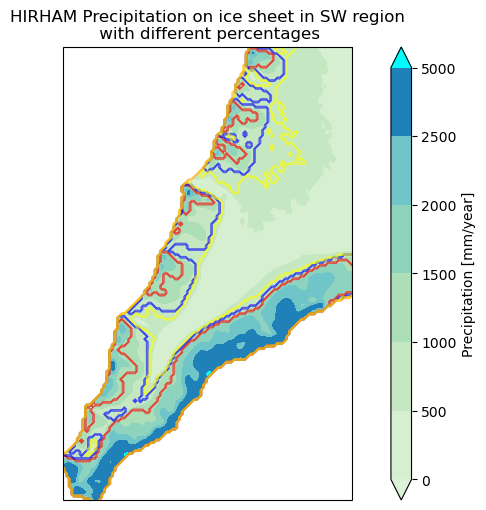

In [165]:
ice_mask = np.squeeze(topoGT2.ice_mask)

da = xr.DataArray(GT2_pr*365.25)
im_pr = da.where(ice_mask>0.,drop=True)

print(im_pr.shape)


plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())
ax.coastlines();
ax.set_title('HIRHAM Precipitation on ice sheet in SW region\n with different percentages')

sw_gl = im_pr[:170,:109]

print(sw_gl)

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

data1 = np.zeros_like(sw_gl)
data1[sw_gl >= fifty_per] = 1

data2 = np.zeros_like(sw_gl)
data2[sw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(sw_gl)
data3[sw_gl >= eighty_per] = 1

data4 = np.zeros_like(sw_gl)
data4[sw_gl >= ninty_per] = 1

data = ax.contourf(sw_gl,cmap=cmp,levels=[0,500,1000,1500,2000,2500,5000],extend='both')    
data.cmap.set_over('cyan')  
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(sw_gl,50)
seventyfive_per = np.nanpercentile(sw_gl,75)
eighty_per = np.nanpercentile(sw_gl,80)
ninty_per = np.nanpercentile(sw_gl,90)
nintynine_per = np.nanpercentile(sw_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

ax.margins(x=0, y=0)
#ax.set_facecolor('lightgray')

gt7

In [168]:
print(im_pr7)

<xarray.DataArray 'pr' (y: 376, x: 239)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y        (y) int64 126 127 128 129 130 131 132 ... 527 528 529 530 559 560
  * x        (x) int64 66 67 68 69 70 71 72 73 ... 298 299 300 301 302 303 304
    lon      (y, x) float32 -47.08 -46.98 -46.89 -46.8 ... -32.33 -31.66 -31.0
    lat      (y, x) float32 61.4 61.43 61.45 61.47 ... 85.9 85.91 85.92 85.93
    height   float64 0.0
    time     datetime64[ns] 2008-12-31T23:00:00


(339, 217)
<xarray.DataArray 'pr' (y: 188, x: 120)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 382.38333, 370.88815,
        368.91415],
       [      nan,       nan,       nan, ..., 374.1458 , 369.44763,
        364.0884 ],
       [      nan,       nan,       nan, ..., 369.72318, 369.26917,
        362.8575 ]], dtype=float32)
Coordinates:
  * y        (y) int64 126 127 128 129 130 131 132 ... 308 309 310 311 312 313
  * x        (x) int64 66 67 68 69 70 71 72 73 ... 179 180 181 182 183 184 185
    lon      (y, x) float32 -47.08 -46.98 -46.89 -46.8 ... -43.12 -42.96 -42.81
    lat      (y, x) float32 61.4 61.43 61.45 61.47 ... 72.3 72.32 72.34 72.36
    height   float64 0.0
    time     datetime64[ns] 2008-12-31

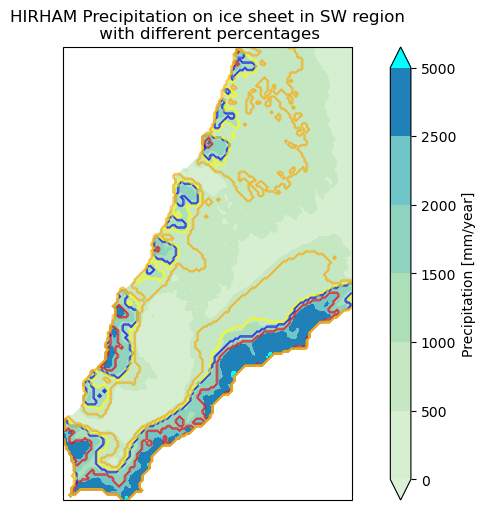

In [171]:
print(im_pr.shape)

plt.figure(figsize=(10,6),dpi=100) 
ax = plt.axes(projection=ccrs.LambertConformal())
ax.coastlines();
ax.set_title('HIRHAM Precipitation on ice sheet in SW region\n with different percentages')

sw_gl = im_pr7[:188,:120]

print(sw_gl)

jet_big = cm.get_cmap('GnBu')
cmp = colors.ListedColormap(jet_big(np.linspace(0.15, 1, 250)))

data1 = np.zeros_like(sw_gl)
data1[sw_gl >= fifty_per] = 1

data2 = np.zeros_like(sw_gl)
data2[sw_gl >= seventyfive_per] = 1

data3 = np.zeros_like(sw_gl)
data3[sw_gl >= eighty_per] = 1

data4 = np.zeros_like(sw_gl)
data4[sw_gl >= ninty_per] = 1

data = ax.contourf(sw_gl,cmap=cmp,levels=[0,500,1000,1500,2000,2500,5000],extend='both')    
data.cmap.set_over('cyan')  
cbar = plt.colorbar(data)
cbar.set_label('Precipitation [mm/year]')

d4 = ax.contour(data4,colors='r',linewidths=0.2)
d3 = ax.contour(data3,colors='blue',linewidths=0.2)
d2 = ax.contour(data2,colors='yellow',linewidths=0.2)
d1 = ax.contour(data1,colors='orange',linewidths=0.2)

fifty_per = np.nanpercentile(sw_gl,50)
seventyfive_per = np.nanpercentile(sw_gl,75)
eighty_per = np.nanpercentile(sw_gl,80)
ninty_per = np.nanpercentile(sw_gl,90)
nintynine_per = np.nanpercentile(sw_gl,99.9)

print('Different percentages where the following amount of precip with lower values:')
print('50%',fifty_per,'mm/year')
print('75%',seventyfive_per)
print('80%',eighty_per)
print('90%',ninty_per)
print('99.9%',nintynine_per,': So 0.01% of the precip is higher than',nintynine_per)

ax.margins(x=0, y=0)
#ax.set_facecolor('lightgray')